In [5]:
# library imports
import numpy as np
from numpy import argmax

import pandas as pd

from glob import glob

import cv2 

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt                      
%matplotlib inline    
import random

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_files       
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

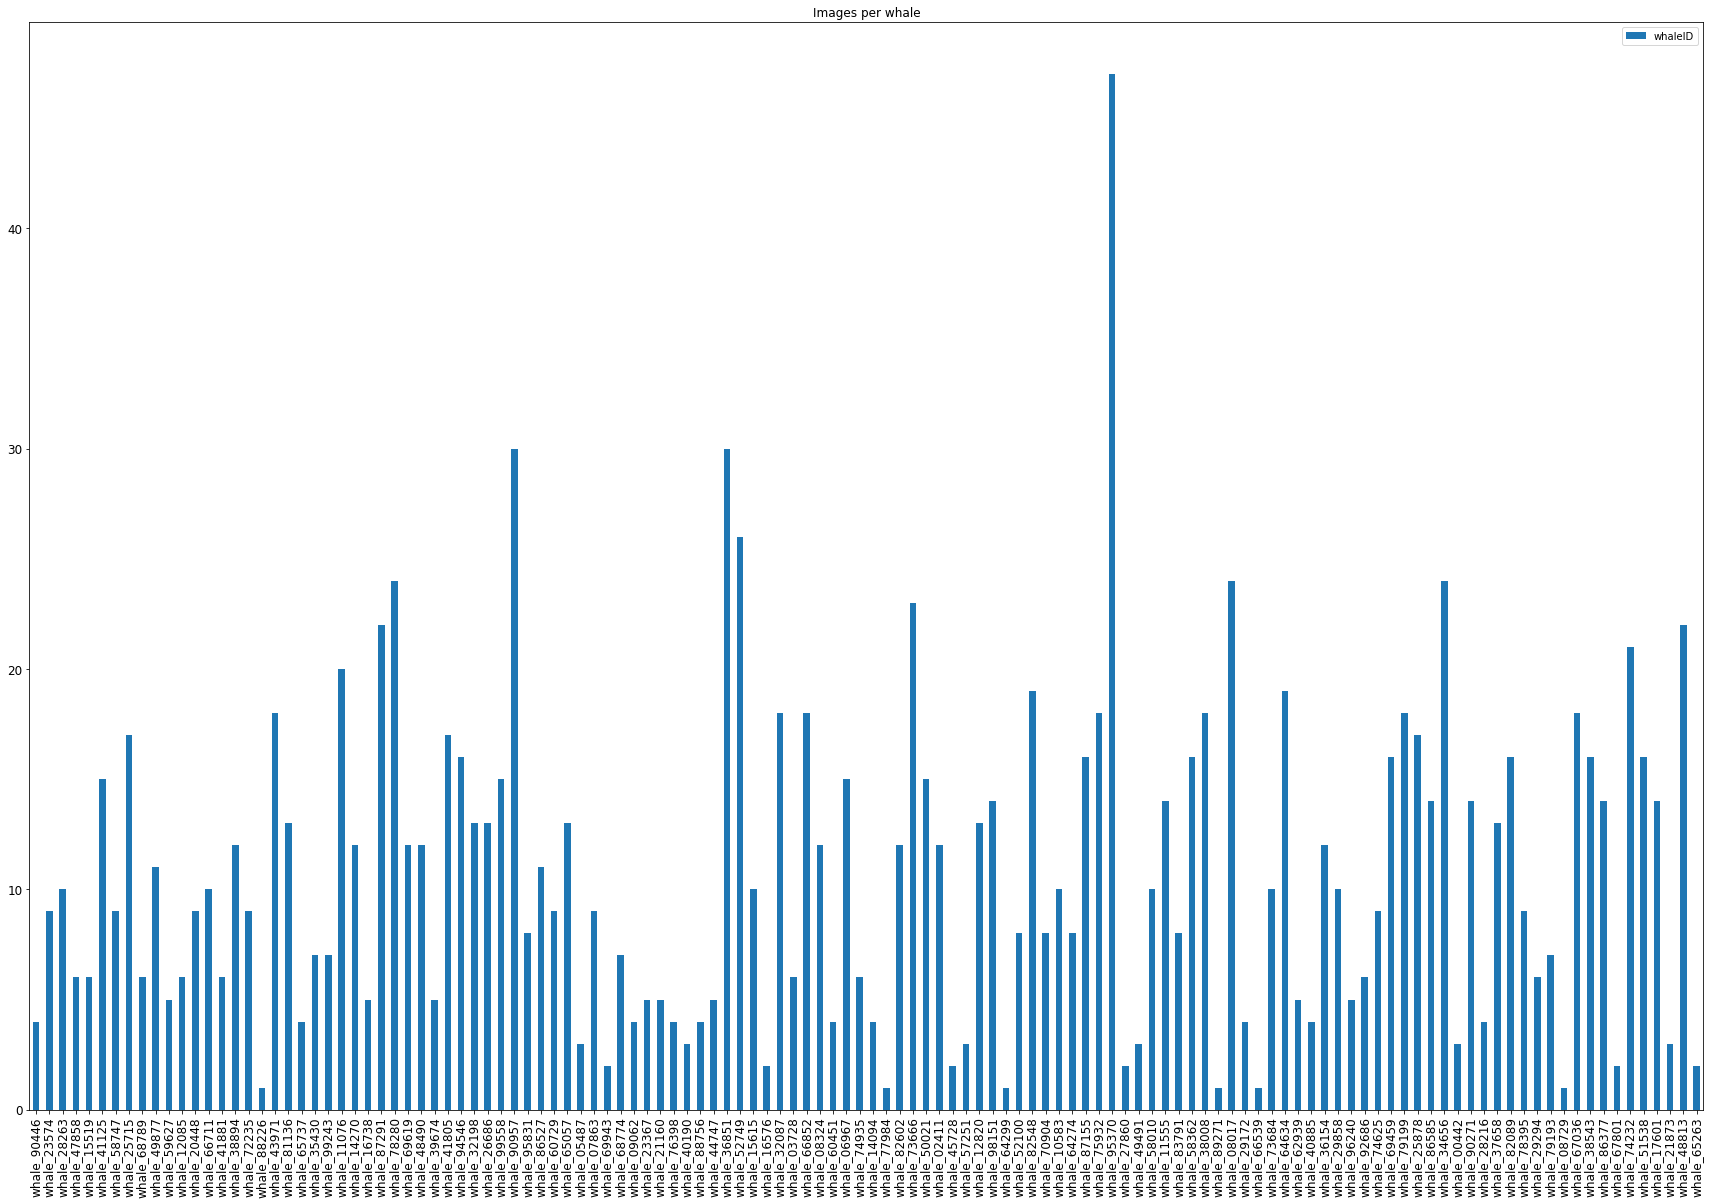

In [6]:
# initialize random seed
random.seed(523532)

# load data
dataframe = pd.read_csv("train.csv")
dataframe = shuffle(dataframe)
# visualize images per whale
temp = dataframe['whaleID'].value_counts()
whaleImgs = pd.DataFrame(temp)
whaleImgs = whaleImgs.sample(frac=1)
whaleImgs = whaleImgs[np.random.rand(len(whaleImgs)) < 0.3]

whaleImgs.plot(kind='bar',figsize=(30,20), title='Images per whale', fontsize=12)


In [ ]:
#df = dataframe
#df = df.groupby('whaleID').filter(lambda x: len(x) > 1 and len(x) > 2 and len(x) > 3)
#print df['whaleID'].value_counts()
#print len(df)

In [7]:
# encoding
dataframe = shuffle(dataframe)
data = dataframe['whaleID']
values = np.array(data)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)
classes = np.array('cropped/' + dataframe['Image'])


In [ ]:
# Code refernce: https://github.com/eduardofv/whale_detector/

%matplotlib inline
# Finding whales for Kaggle's NOAA Right Whale Recognition Challenge
# https://www.kaggle.com/c/noaa-right-whale-recognition

import sys
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Get the histogram. All histograms must be the same kind
def getHist(im):
    hist = cv2.calcHist([im],[0,1,2],None,[16,16,16],[0,255,0,255,0,255])
    return(hist)

# Divide the image in four subimages
def divImage(im):
    height,width,channels = im.shape
    im1 = im[0:int(height/2), 0:int(width/2)]
    im2 = im[0:int(height/2), int(width/2):width]
    im3 = im[int(height/2):height, 0:int(width/2)]
    im4 = im[int(height/2):height, int(width/2):width]
    return([im1,im2,im3,im4])

# Sets a whole image to a value. By default, black
def setImage(im,val=0):
    for i in range(0,3):
        im[:,:,i]=val

#  Create a mask image to select regions with a distinct histogram. 
#  white zones are different enough from the base image
#  im: image
#  baseHist: Histogram of the base image (currently, the original image)
#  label: A label for the current step, just for debug 
def simHist(im, baseHist, label=""):
    #print label
    height,width,channels = im.shape
    if width < 10 or height < 10:
        setImage(im,0)
        return
    images = divImage(im)
    histg = baseHist
    # Test: this compares each subimage with the current image's histogram instead of the base (whole image)
    # histg = getHist(im)
    # CORREL: Other similarity measures may be tested
    sim = [cv2.compareHist(histg, getHist(imx), cv2.HISTCMP_CORREL) for imx in images]

    for i in range(0,len(sim)):
        # This is the threshold to consider too different 
        if sim[i] < 0.25:
            setImage( images[i], 255 )
        else:
            sim.append( simHist( images[i], histg, label+str(i) ) )

    return(sim)

# Show a image, somewhat adjusted to fit screen
def show(name,imx):
    # height,width,channels = imx.shape
    # orgfx = 600.0 / width
    # imx = cv2.resize(imx,None,fx=orgfx,fy=orgfx,interpolation=cv2.INTER_CUBIC)
    # cv2.imshow(name,imx)
    plt.imshow(imx)
    plt.show()

# CLAHE as suggested by @dietCoke
def clahe(rgb):
    claheizer = cv2.createCLAHE()
    lab = cv2.cvtColor(rgb.astype('uint8'), cv2.COLOR_RGB2Lab)
    lab[:,:,0] = claheizer.apply(lab[:,:,0])
    rgb = cv2.cvtColor(lab.astype('uint8'), cv2.COLOR_Lab2RGB)
    return rgb



In [ ]:
# Code refernce: https://github.com/eduardofv/whale_detector/
# Generate cropped images
# run once only to crop the images

for path in sample:
    im = cv2.imread(path)
    if im is None:
        print('Failed to load image file:', path)
        sys.exit(1)

    org = im

%matplotlib inline
    # PREPROCESS
    # Convert to HSV, yields better results than BGR
    im = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
    
    # get original image hist
    baseHist = getHist(im)

    # PROCESS
    # Perform region selection by histogram similarity. Returns a mask on whole image
    res = simHist(im,baseHist)

    # POST
    # Clean blobs detected
    kernel = np.ones((40,40),np.uint8)
    im = cv2.erode(im,kernel,iterations=1)
    im = cv2.dilate(im,kernel,iterations=1)

    # Mark regions
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(im,127,255,0)
    _,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    best = None
    best_size = 0
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        size = w * h
        if w > h :
            w = h
        else:
            h = w      
        if size > best_size:
            best_size = size
            best = cnt
        cv2.rectangle(im,(x-10,y-10),(x+w+10,y+h+10),(255,255,255),2)

    # Select biggest contour, assume that's the whale :D
    # shows boundng box and contour
    if best_size > 0:
        bx,by,bw,bh = cv2.boundingRect(best)
        # crop image as a square 
        if bw > bh:
            bh = bw
        else:
            bw = bh  
        extract = org[ by:(by+bh), bx:(bx+bw) ]
        mask = im[ by:(by+bh), bx:(bx+bw) ]

        # save extract and mask
        cv2.imwrite('cropped/' + path ,extract)


In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(classes, labels, test_size=0.20, random_state=42)

In [234]:
#print label_encoder.inverse_transform([argmax(y_train[12])])
#print X_train[12]

['whale_34663']
cropped/w_2281.jpg


In [9]:
# Keras preprocessing
# code reference: Udacity's dog breed project - https://github.com/udacity/dog-project

ImageFile.LOAD_TRUNCATED_IMAGES = True   

def path_to_tensor(img_path): 
    # loads RGB image as PIL.Image.Image type 
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
# code reference: Udacity's dog breed project - https://github.com/udacity/dog-project
              
# pre-process the data for Keras

train_tensors = paths_to_tensor(X_train).astype('float32')/255
test_tensors = paths_to_tensor(X_test).astype('float32')/255

100%|██████████| 909/909 [00:51<00:00, 17.49it/s]


In [11]:
# benchmark CNN architecture

modelBM = Sequential()

modelBM.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))

modelBM.add(GlobalAveragePooling2D())
modelBM.add(Dense(447, activation='softmax'))

modelBM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 16)      208       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 447)               7599      
Total params: 7,807
Trainable params: 7,807
Non-trainable params: 0
_________________________________________________________________


In [12]:
modelBM.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [178]:
epochs =20

histBM = modelBM.fit(train_tensors, y_train, 
          epochs=epochs, batch_size=20, verbose=1)


modelBM.save_weights('models/benchmark_crop3.h5') 

Epoch 1/20
3635/3635 [==============================] - 54s 15ms/step - loss: 5.9999 - acc: 0.0052
Epoch 2/20
3635/3635 [==============================] - 60s 17ms/step - loss: 5.9148 - acc: 0.0102
Epoch 3/20
3635/3635 [==============================] - 55s 15ms/step - loss: 5.8994 - acc: 0.0110
Epoch 4/20
3635/3635 [==============================] - 52s 14ms/step - loss: 5.8919 - acc: 0.0110
Epoch 5/20
3635/3635 [==============================] - 52s 14ms/step - loss: 5.8886 - acc: 0.0110
Epoch 6/20
3635/3635 [==============================] - 52s 14ms/step - loss: 5.8841 - acc: 0.0110
Epoch 7/20
3635/3635 [==============================] - 52s 14ms/step - loss: 5.8820 - acc: 0.0110
Epoch 8/20
3635/3635 [==============================] - 52s 14ms/step - loss: 5.8802 - acc: 0.0110
Epoch 9/20
3635/3635 [==============================] - 54s 15ms/step - loss: 5.8788 - acc: 0.0110
Epoch 10/20
3635/3635 [==============================] - 53s 15ms/step - loss: 5.8769 - acc: 0.0110
Epoch 11/

In [13]:
modelBM.load_weights('models/benchmark_crop3.h5')

In [14]:
scoreBM = modelBM.evaluate(test_tensors, y_test, verbose=1)

909/909 [==============================] - 4s 5ms/step


In [15]:
print 'Cross entropy: {}'.format(scoreBM[0])
print 'Accuracy: {}'.format(scoreBM[1])

Cross entropy: 5.91376208105
Accuracy: 0.014301430184


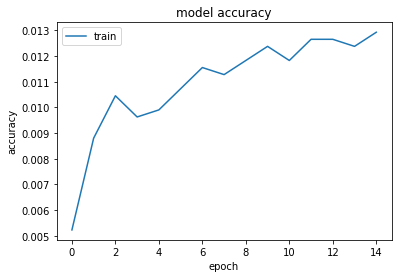

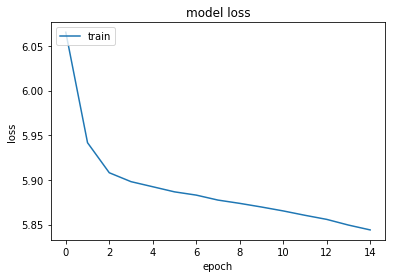

In [116]:
# summarize history for accuracy
plt.plot(histBM.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histBM.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# model architecture

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256, kernel_size=2, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())
model.add(Dense(447, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        16448     
__________

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
# real time augmantation from Keras https://keras.io/preprocessing/image/
# not applied

#datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True)

#datagen.fit(train_tensors)

In [ ]:
# augmantation trial
#hist_aug = model.fit_generator(datagen.flow(train_tensors, y_train, batch_size=32), epochs=15)

#model.save_weights('models/finalmodel_crop_augm1.h5') 

In [68]:
#model.load_weights('models/finalmodel_crop_augm1.h5')
#score = model.evaluate(test_tensors, y_test, verbose=10)
#print 'Cross entropy: {}'.format(score[0])
#print 'Accuracy: {}%'.format(score[1]*100)

Cross entropy: 16.0254941212
Accuracy: 0.0%


In [109]:
# trial
#hist = model.fit(train_tensors, y_train, epochs=15, batch_size=20, verbose=1)

#model.save_weights('models/finalmodel_crop3.h5') 

Epoch 1/15
3635/3635 [==============================] - 127s 35ms/step - loss: 6.0426 - acc: 0.0058
Epoch 2/15
3635/3635 [==============================] - 127s 35ms/step - loss: 5.9449 - acc: 0.0091
Epoch 3/15
3635/3635 [==============================] - 126s 35ms/step - loss: 5.9173 - acc: 0.0083
Epoch 4/15
3635/3635 [==============================] - 126s 35ms/step - loss: 5.9081 - acc: 0.0085
Epoch 5/15
3635/3635 [==============================] - 127s 35ms/step - loss: 5.9006 - acc: 0.0074
Epoch 6/15
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8967 - acc: 0.0094
Epoch 7/15
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8941 - acc: 0.0096
Epoch 8/15
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8937 - acc: 0.0099
Epoch 9/15
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8902 - acc: 0.0094
Epoch 10/15
3635/3635 [==============================] - 127s 35ms/step - loss: 5.8892 - acc: 0.0085

In [ ]:
#model.load_weights('models/finalmodel_crop3.h5')

In [112]:
#score = model.evaluate(test_tensors, y_test, verbose=1)
#print 'Cross entropy: {}'.format(score[0])
#print 'Accuracy: {}'.format(score[1])

Cross entropy: 5.99240297846
Accuracy: 0.014301430143


In [117]:
# trial
#hist2 = model.fit(train_tensors, y_train, epochs=50, batch_size=50, verbose=1)

#model.save_weights('models/finalmodel_crop4.h5') 

Epoch 1/50
3635/3635 [==============================] - 491s 135ms/step - loss: 5.7628 - acc: 0.0121
Epoch 2/50
3635/3635 [==============================] - 134s 37ms/step - loss: 5.7172 - acc: 0.0129
Epoch 3/50
3635/3635 [==============================] - 123s 34ms/step - loss: 5.6589 - acc: 0.0138
Epoch 4/50
3635/3635 [==============================] - 123s 34ms/step - loss: 5.5752 - acc: 0.0184
Epoch 5/50
3635/3635 [==============================] - 123s 34ms/step - loss: 5.4983 - acc: 0.0212
Epoch 6/50
3635/3635 [==============================] - 123s 34ms/step - loss: 5.3812 - acc: 0.0319
Epoch 7/50
3635/3635 [==============================] - 125s 34ms/step - loss: 5.2422 - acc: 0.0459
Epoch 8/50
3635/3635 [==============================] - 123s 34ms/step - loss: 5.0474 - acc: 0.0657
Epoch 9/50
3635/3635 [==============================] - 123s 34ms/step - loss: 4.8678 - acc: 0.0845
Epoch 10/50
3635/3635 [==============================] - 123s 34ms/step - loss: 4.6651 - acc: 0.108

In [118]:
#score = model.evaluate(test_tensors, y_test, verbose=10)
#print 'Cross entropy: {}'.format(score[0])
#print 'Accuracy: {}'.format(score[1])

Cross entropy: 13.0815844489
Accuracy: 0.019801980198


In [130]:
# trial
#hist2 = model.fit(train_tensors, y_train, epochs=25, batch_size=100, verbose=1)

#model.save_weights('models/finalmodel_crop5.h5') 

Epoch 1/25
3635/3635 [==============================] - 136s 38ms/step - loss: 5.9996 - acc: 0.0096
Epoch 2/25
3635/3635 [==============================] - 124s 34ms/step - loss: 5.9435 - acc: 0.0083
Epoch 3/25
3635/3635 [==============================] - 123s 34ms/step - loss: 5.9204 - acc: 0.0085
Epoch 4/25
3635/3635 [==============================] - 121s 33ms/step - loss: 5.9141 - acc: 0.0096
Epoch 5/25
3635/3635 [==============================] - 119s 33ms/step - loss: 5.9077 - acc: 0.0096
Epoch 6/25
3635/3635 [==============================] - 121s 33ms/step - loss: 5.9026 - acc: 0.0085
Epoch 7/25
3635/3635 [==============================] - 123s 34ms/step - loss: 5.8981 - acc: 0.0096
Epoch 8/25
3635/3635 [==============================] - 122s 33ms/step - loss: 5.8976 - acc: 0.0096
Epoch 9/25
3635/3635 [==============================] - 123s 34ms/step - loss: 5.8970 - acc: 0.0091
Epoch 10/25
3635/3635 [==============================] - 123s 34ms/step - loss: 5.8944 - acc: 0.0099

In [131]:
#score = model.evaluate(test_tensors, y_test, verbose=10)
#print 'Cross entropy: {}'.format(score[0])
#print 'Accuracy: {}'.format(score[1])

Cross entropy: 5.95654713911
Accuracy: 0.01100110011


In [181]:
hist3 = model.fit(train_tensors, y_train, epochs=20, batch_size=20, verbose=1)

model.save_weights('models/finalmodel_crop5.h5') 

Epoch 1/20
3635/3635 [==============================] - 131s 36ms/step - loss: 6.0356 - acc: 0.0083
Epoch 2/20
3635/3635 [==============================] - 127s 35ms/step - loss: 5.9331 - acc: 0.0110
Epoch 3/20
3635/3635 [==============================] - 127s 35ms/step - loss: 5.9117 - acc: 0.0110
Epoch 4/20
3635/3635 [==============================] - 127s 35ms/step - loss: 5.9009 - acc: 0.0110
Epoch 5/20
3635/3635 [==============================] - 127s 35ms/step - loss: 5.8941 - acc: 0.0110
Epoch 6/20
3635/3635 [==============================] - 127s 35ms/step - loss: 5.8933 - acc: 0.0110
Epoch 7/20
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8888 - acc: 0.0110
Epoch 8/20
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8860 - acc: 0.0110
Epoch 9/20
3635/3635 [==============================] - 130s 36ms/step - loss: 5.8845 - acc: 0.0110
Epoch 10/20
3635/3635 [==============================] - 135s 37ms/step - loss: 5.8867 - acc: 0.0110

In [187]:
score = model.evaluate(test_tensors, y_test, verbose=1)


909/909 [==============================] - 11s 12ms/step


In [188]:
print 'Cross entropy: {}'.format(score[0])
print 'Accuracy: {}'.format(score[1])

Cross entropy: 6.00123282287
Accuracy: 0.00770077007701


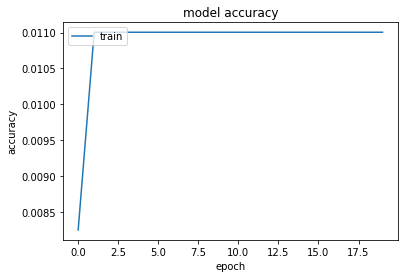

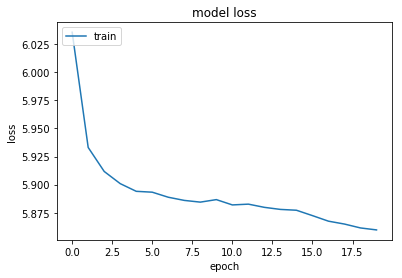

In [189]:
# summarize history for accuracy
plt.plot(hist3.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
#test = paths_to_tensor(test)
prediction = model.predict(np.expand_dims(test_tensors[124], axis=0))
#print prediction

print label_encoder.inverse_transform([argmax(y_test[124])]), X_test[124]
print label_encoder.inverse_transform(np.argmax(prediction))
#print np.argmax(y_test[10])

['whale_87604'] cropped/w_6947.jpg
whale_95370


In [21]:
model.load_weights('models/finalmodel_crop5.h5')

In [19]:
score = model.evaluate(test_tensors, y_test, verbose=10)
print 'Cross entropy: {}'.format(score[0])
print 'Accuracy: {}'.format(score[1])

Cross entropy: 5.90934458503
Accuracy: 0.014301430184


In [29]:
# trial
#hist4 = model.fit(train_tensors, y_train, epochs=30, batch_size=20, verbose=1)

#model.save_weights('models/finalmodel_crop7.h5') 

Epoch 1/30
3635/3635 [==============================] - 140s 39ms/step - loss: 5.9035 - acc: 0.0094
Epoch 2/30
3635/3635 [==============================] - 132s 36ms/step - loss: 5.8968 - acc: 0.0094
Epoch 3/30
3635/3635 [==============================] - 136s 37ms/step - loss: 5.8871 - acc: 0.0116
Epoch 4/30
3635/3635 [==============================] - 140s 38ms/step - loss: 5.8738 - acc: 0.0110
Epoch 5/30
3635/3635 [==============================] - 129s 36ms/step - loss: 5.8571 - acc: 0.0116
Epoch 6/30
3635/3635 [==============================] - 128s 35ms/step - loss: 5.8442 - acc: 0.0110
Epoch 7/30
3635/3635 [==============================] - 134s 37ms/step - loss: 5.8275 - acc: 0.0127
Epoch 8/30
3635/3635 [==============================] - 126s 35ms/step - loss: 5.8182 - acc: 0.0118
Epoch 9/30
3635/3635 [==============================] - 129s 35ms/step - loss: 5.8110 - acc: 0.0118
Epoch 10/30
3635/3635 [==============================] - 129s 35ms/step - loss: 5.8021 - acc: 0.0110

In [30]:
#score_trial7 = model.evaluate(test_tensors, y_test, verbose=10)
#print 'Cross entropy: {}'.format(score_trial7[0])
#print 'Accuracy: {}'.format(score_trial7[1])

Cross entropy: 6.01449298124
Accuracy: 0.017601760217


In [ ]:
# tried solution - long training time and overfitted
# transfer learning code reference: https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

#img_width, img_height = 256, 256

#modelVGG19 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


In [ ]:
# freeze first 5 layers
#for layer in model.layers[:5]:
#    layer.trainable = False

# custom Layers 
#x = modelVGG19.output
#x = Dropout(0.3)(x)
#x = Flatten()(x)
#predictions = Dense(447, activation="softmax")(x)

#modelVGG19_final = Model(input = modelVGG19.input, output = predictions)

#modelVGG19_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
# train the model 
#modelhist = modelVGG19_final.fit(train_tensors, y_train, epochs=20, batch_size=20, verbose=1)

#modelVGG19_final.save_weights('models/tl_crop1.h5') 